# Assignment 3 Q1

In [597]:
%run ../../resources/resources.ipynb

In [598]:
# load geometry
with open('MainFoil_N=100.csv', 'r') as infile:
    x_main, y_main = np.loadtxt(infile, delimiter=',', dtype=float, unpack=True)
    
with open('FlapFoil_N=100.csv', 'r') as infile:
    x_flap, y_flap = np.loadtxt(infile, delimiter=',', dtype=float, unpack=True)

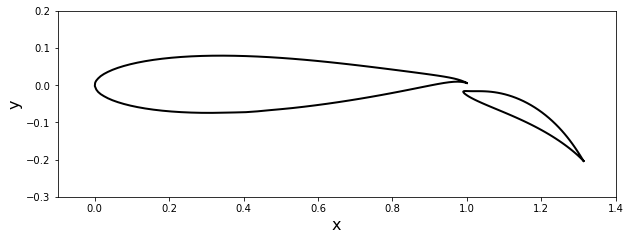

In [599]:
#plot geometry
width = 10
plt.figure(figsize=(width,width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_main, y_main, color='k', linewidth=2, linestyle='-')
plt.plot(x_flap, y_flap, color='k', linewidth=2, linestyle='-')
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.4)
plt.ylim(-0.3, 0.2);

In [600]:
# discretize main foil
N = 100
main_panels = define_panels(x_main, y_main, N)

In [601]:
# discretize flap
flap_panels = define_panels(x_flap/np.cos(np.pi/6), y_flap/np.sin(np.pi/6), N)
for panel in flap_panels:
    panel.xa *= np.cos(np.pi/6)
    panel.xb *= np.cos(np.pi/6)
    panel.ya *= np.sin(np.pi/6)
    panel.yb *= np.sin(np.pi/6)
    panel.xc = (panel.xa + panel.xb)/2
    panel.yc = (panel.ya + panel.yb)/2
    panel.length = np.sqrt((panel.xb-panel.xa)**2 + (panel.yb-panel.ya)**2)
    if (panel.xb-panel.xa) <= 0:
        panel.beta = np.arccos((panel.yb-panel.ya)/panel.length)
    elif (panel.xb-panel.xa) > 0:
        panel.beta = np.pi + np.arccos(-(panel.yb-panel.ya)/panel.length)

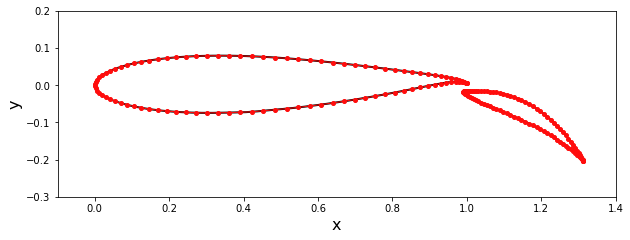

In [602]:
# plot
width = 10
plt.figure(figsize=(width,width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_main, y_main, color='k', linewidth=2, linestyle='-')
plt.plot(x_flap, y_flap, color='k', linewidth=2, linestyle='-')
plt.plot([panel.xc for panel in main_panels], [panel.yc for panel in main_panels],
         color='#FF0D0D', linewidth=1, marker='o', markersize=4)
plt.plot([panel.xc for panel in flap_panels], [panel.yc for panel in flap_panels],
         color='#FF0D0D', linewidth=1, marker='o', markersize=4)
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.4)
plt.ylim(-0.3, 0.2);

In [603]:
# create full panel array and declare free stream
panels = np.append(main_panels, flap_panels)
fs = Freestream(u_inf=1.0, alpha=0.0)

In [604]:
# define integral function
def integral(x, y, panel, dxdz, dydz):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - s*np.sin(panel.beta)))*dxdz
                 +(y - (panel.ya + s*np.cos(panel.beta)))*dydz)
                /((x - (panel.xa - s*np.sin(panel.beta)))**2
                 +(y - (panel.ya + s*np.cos(panel.beta)))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [605]:
# define source normal matrix
def source_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = np.empty((panels.size, panels.size), dtype=float)
    
    np.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/np.pi*integral(p_i.xc, p_i.yc, p_j, np.cos(p_i.beta), np.sin(p_i.beta))
                
    return A

In [606]:
# define vortex normal matrix
def vortex_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = np.empty((panels.size, panels.size), dtype=float)
    
    np.fill_diagonal(A, 0.0)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/np.pi*integral(p_i.xc, p_i.yc, p_j, np.sin(p_i.beta), -np.cos(p_i.beta))
                
    return A

In [607]:
# create source and vortex normal arrays
A_n = source_normal(panels)
B_n = vortex_normal(panels)

/home/bob/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in double_scalars
/home/bob/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [608]:
def kutta_condition(A, B):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    Na = int(B.shape[1]/2)
    b = np.empty([2, A.shape[1] + 2], dtype=float)
    
    b[0, :-2] = B[0, :] + B[Na-1, :]
    
    b[1, :-2] = B[Na, :] + B[-1, :]
    
    b[0, -2] = -np.sum(A[0, :Na]) + np.sum(A[Na-1, :Na])
    
    b[0, -1] = -np.sum(A[0, Na:]) + np.sum(A[Na-1, Na:])
    
    b[1, -2] = -np.sum(A[Na, :Na]) + np.sum(A[-1, :Na])
    
    b[1, -1] = -np.sum(A[Na, Na:]) + np.sum(A[-1, Na:])
    
    return b

In [609]:
# create singularity matrix
def build_matrix(A_s, B_v):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_s: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_v: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    Na = int(A_s.shape[1]/2)
    A = np.empty((A_s.shape[0]+2, A_s.shape[1]+2))
    
    A[:-2, :-2] = A_s
    
    A[:-2, -2] = np.sum(B_v[:, :Na], axis=1)
    A[:-2, -1] = np.sum(B_v[:, Na:], axis=1)
    
    b = kutta_condition(A_s, B_v)
    A[-2, :] = b[0, :]
    A[-1, :] = b[1, :]
    
    return A

In [610]:
# create RHS vector
def build_rhs(panels, fs):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    fs: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    Na = int(panels.size/2)
    b = np.empty(panels.size + 2, dtype=float)
    for i, panel in enumerate(panels[:Na]):
        if i < Na:
            b[i] = -fs.u_inf*np.cos(fs.alpha-panel.beta)
        else:
            b[i] = -fs.u_inf*np.cos(fs.alpha+np.pi/6-panel.beta)
    
    b[-2] = -fs.u_inf*(np.sin(fs.alpha-panels[0].beta) + np.sin(fs.alpha-panels[Na-1].beta))
    b[-1] = -fs.u_inf*(np.sin(fs.alpha+np.pi/6-panels[Na].beta) + np.sin(fs.alpha+np.pi/6-panels[-1].beta))
    
    return b

In [611]:
A = build_matrix(A_n, B_n)

In [612]:
b = build_rhs(panels, fs)

In [613]:
strengths = np.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = strengths[i]
    
gamma_main = strengths[-2]
gamma_flap = strengths[-1]

gamma = np.append(gamma_main, gamma_flap)

In [614]:
# compute tangential velocity
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    Na = int(panels.size/2)
    A = np.empty((panels.size, panels.size+2), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-2] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -2] = -np.sum(A_source[:, :Na], axis=1)
    A[:, -1] = -np.sum(A_source[:, Na:], axis=1)
    # freestream contribution
    b = freestream.u_inf*np.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = np.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [615]:
compute_tangential_velocity(panels, fs, gamma, A_n, B_n)

In [616]:
for panel in panels:
    panel.cp = 1.0 - (panel.vt/fs.u_inf)**2

In [617]:
# theoretical values
with open('Cp_Main_theoretical.csv', 'r') as infile:
    x_m_theo, y_m_theo = np.loadtxt(infile, delimiter=',', dtype=float, unpack=True)
    
with open('Cp_Flap_theoretical.csv', 'r') as infile:
    x_f_theo, y_f_theo = np.loadtxt(infile, delimiter=',', dtype=float, unpack=True)

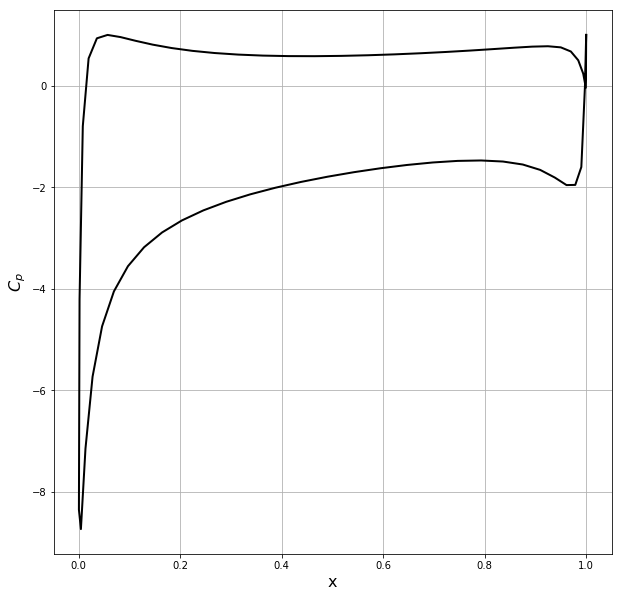

In [618]:
# plot
width = 10
plt.figure(figsize=(width,width))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels[:N]], [panel.cp for panel in panels[:N]], color='#FF0D0D', linewidth=2, linestyle='-')
plt.plot(x_m_theo, y_m_theo, color='k', linewidth=2);
#plt.axis('scaled', adjustable='box')